In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import cv2

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=1

#### Breakdown Dataset
```80% => TRAIN ```
``` 20% => 10% VAL , 10% TEST ```
#### storing in Dataset Dir respectively

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "res/TRAIN",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "res/TEST",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "res/TEST",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1852 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [9]:
class_names = train_dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [10]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
ii=0                                                    # testing for a image in dataset
print(image_batch[ii].numpy)                            #1st image numpy of the image batch
print(image_batch[ii].shape)

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in train_dataset.take(10):                  #Taking the Batch=1
    plt.title("BATCH Image Set")
    for i in range(BATCH_SIZE):
        #ax = plt.subplot(8,4, i + 1)
        plt.subplot(8,4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### ``` sample code to partition dataset ```

``def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000): 
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)``
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

``train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)``


In [11]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
train_ds = train_dataset
test_ds = test_dataset
val_ds = val_dataset

58
10
10


### Cache, Shuffle, and Prefetch the Dataset   
## DATASET PIPLINEING

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
Building the Model

DataSet Preprocessing

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [16]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])



In [17]:
model.build(input_shape=INPUT_SHAPE)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
historyy = model.fit(
    train_ds,
    epochs=1,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

58/58 [==============================] - 129s 2s/step - loss: 0.9832 - accuracy: 0.4293 - val_loss: 1.1207 - val_accuracy: 0.3333


In [20]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 4s 377ms/step - loss: 1.1207 - accuracy: 0.3333


In [21]:
print(historyy.params)
#print(history.histroy.keys())


{'verbose': 1, 'epochs': 1, 'steps': 58}


In [51]:
model.save('potato_leaf_classify.h5')

## Make prediction

1/1 [==============================] - 1s 516ms/step
actual label:  Potato___Late_blight
predicted Label:  Potato___Late_blight


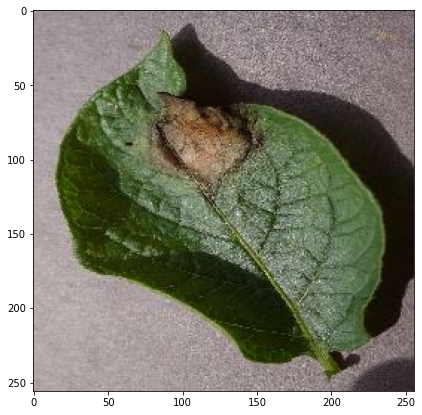

In [39]:
import numpy as np
'''for images_batch,labels_batch in test_ds.take(1):
    image_tobe_predicted = image_batch[0].numpy().astype('uint8')'''
ii=0
plt.figure(figsize=(7, 7))
for images_batch,labels_batch in test_ds.take(1):
    plt.imshow(images_batch[ii].numpy().astype('uint8'))
    batch_prediction = model.predict(images_batch)
    print("actual label: ",class_names[labels_batch[ii].numpy()])
    print("predicted Label: ",class_names[np.argmax(batch_prediction[ii])])

### SAVE the MODEL

In [ ]:
import os

In [ ]:
model_version = max([int(i) for i in os.listdir("saved_models")] +[0])+1 
model.save(f"saved_models/{model_version}")